In [0]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
from numpy import genfromtxt
from numpy.linalg import svd
import csv

In [0]:
def SSA(arr, L):
    K = len(arr) - L + 1

    #create trajectory matrix
    X = np.array([arr.values[i:L+i] for i in range(0, K)]).T
    size = np.linalg.matrix_rank(X)

    #SVD
    U, Sigma, VT = svd(img, full_matrices=False)
    
    #create Hankel's matrix
    X_elem = np.array([ Sigma[i]*np.outer(U[:,i], VT[i,:]) for i in range(size) ])
           
    for i in range(size):
      X_rev = X_elem[i, ::-1]
      TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]


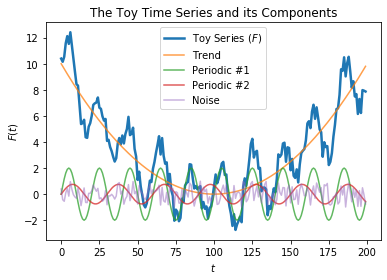

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

In [0]:
#from https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def sigma(self):
          return self.Sigma
        
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
       

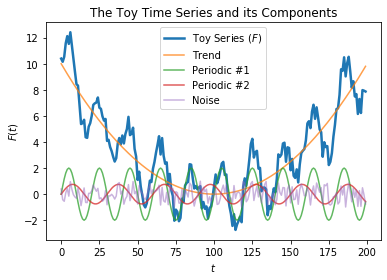

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

In [0]:
def plots(F, c):
    F_ssa = SSA(F, c)

    height = F_ssa.sigma()[0:c]
    x = np.arange(c)
    plt.bar(x, height)
    plt.show()

    F_ssa.reconstruct(0).plot()
    F_ssa.reconstruct(0).plot()
    F_ssa.reconstruct([1,2]).plot()
    F_ssa.reconstruct([3,4]).plot()
    F_ssa.reconstruct([4,5]).plot()
    F_ssa.orig_TS.plot(alpha=0.4)
    plt.title("")
    plt.xlabel(r"")
    plt.ylabel("")
    plt.show()

In [0]:
def val_plot(F, c):
    F_ssa = SSA(F, c)

    height = F_ssa.sigma()[0:c]
    x = np.arange(c)
    plt.scatter(x, height)

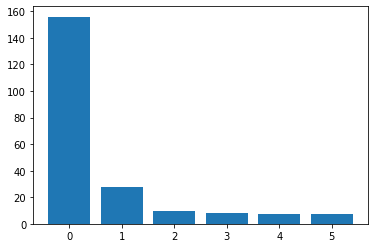

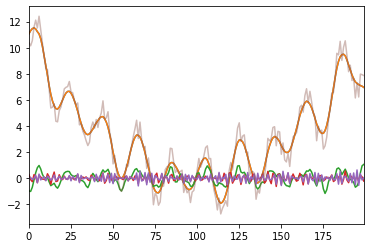

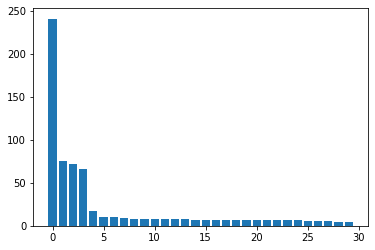

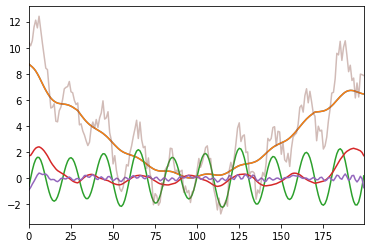

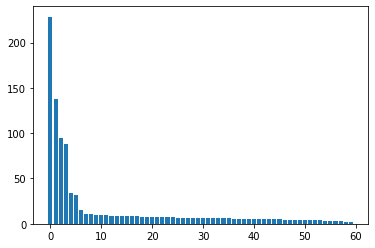

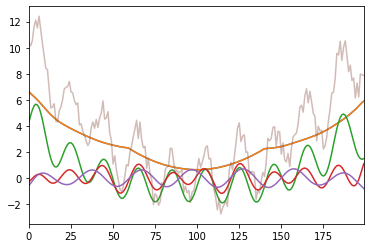

In [0]:
plots(F, 6)
plots(F, 30)
plots(F, 60)

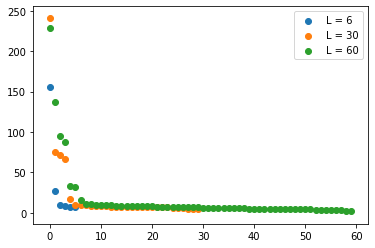

In [0]:
val_plot(F, 6)
val_plot(F, 30)
val_plot(F, 60)
plt.legend(["L = 6", "L = 30", "L = 60"])

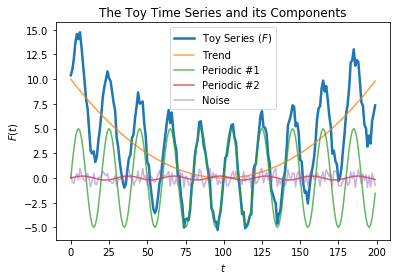

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 5 * np.sin(2*pi*t/p1)
periodic2 = 0.2 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

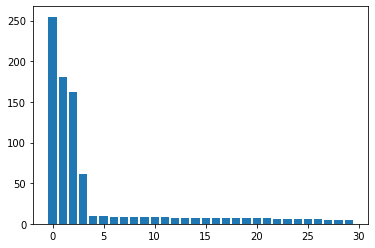

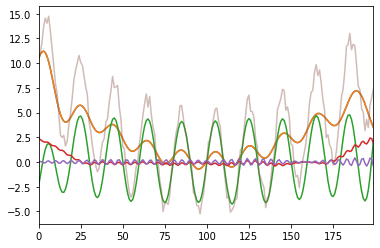

In [0]:
plots(F, 30)

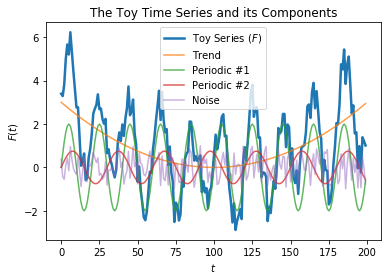

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.0003 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

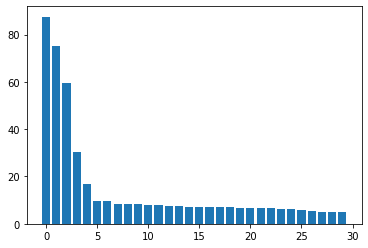

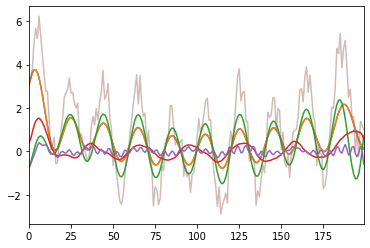

In [0]:
plots(F, 30)

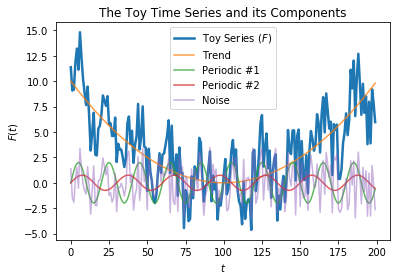

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 7 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

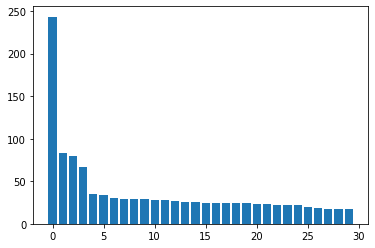

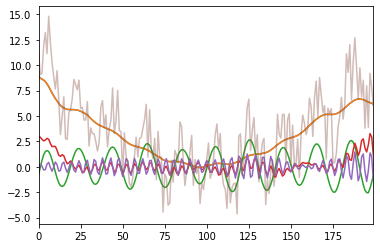

In [0]:
plots(F, 30)

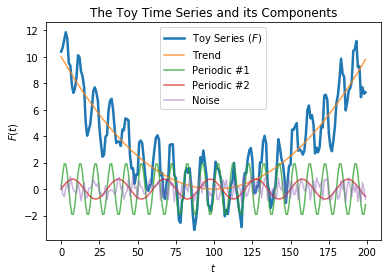

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 10, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

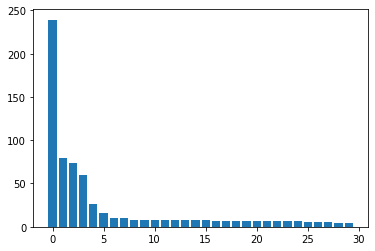

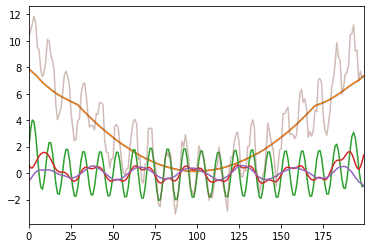

In [0]:
plots(F, 30)

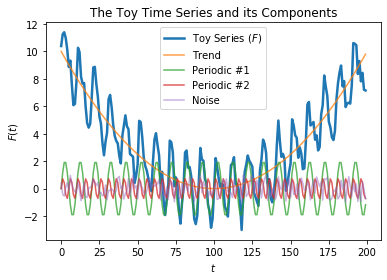

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 10, 5
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

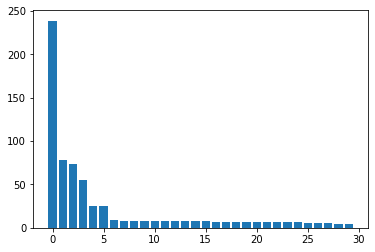

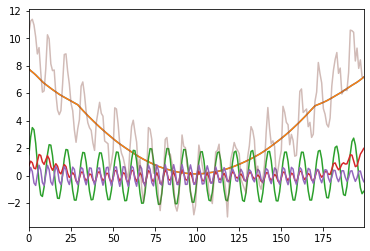

In [0]:
plots(F, 30)

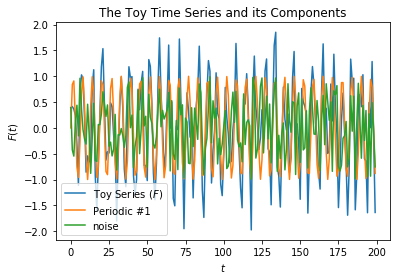

In [0]:
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
periodic1 = np.sin(t)
F = periodic1  + noise

# Plot everything
plt.plot(t, F)
plt.plot(t, periodic1)
plt.plot(t, noise)
plt.legend(["Toy Series ($F$)", "Periodic #1", "noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

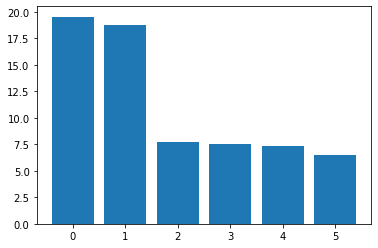

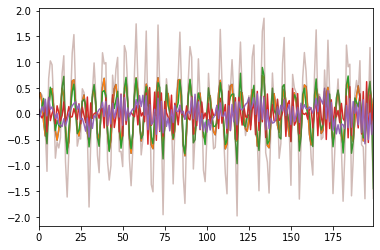

In [0]:
plots(F, 6)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv("/content/gdrive/My Drive/SN_m_tot_V2.0.csv")
#data = np.array(data)
print(data)
print(len(data))

       96.7
0     104.3
1     116.7
2      92.8
3     141.7
4     139.2
...     ...
3246    0.5
3247    1.1
3248    0.4
3249    0.5
3250    1.6

[3251 rows x 1 columns]
3251


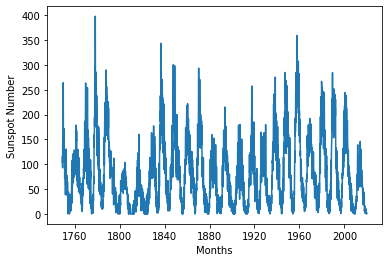

In [0]:
time = pd.date_range('1/1/1749', '12/1/2019', freq='1M')
first_col = np.arange(0, 3252, 1)
cols = [first_col, data]
accel_1 = (data**2).sum(axis=1)**0.5
#accel_1.index /= 50

plt.plot(time, accel_1)
plt.xlabel(r"Months")
plt.ylabel("Sunspot Number")
plt.title("");

In [0]:
start = 0
end =  3252
window = 143
accel_ssa = SSA(accel_1.loc[start:end], window)

<BarContainer object of 50 artists>

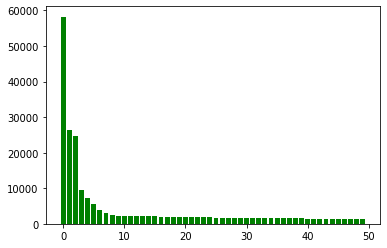

In [0]:
height = accel_ssa.sigma()[0:50]
x = np.arange(50)
plt.bar(x, height, color="green")

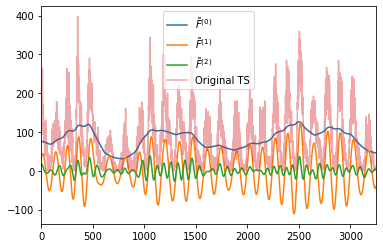

In [0]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("")
plt.xlabel(r"")
plt.ylabel("")

legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

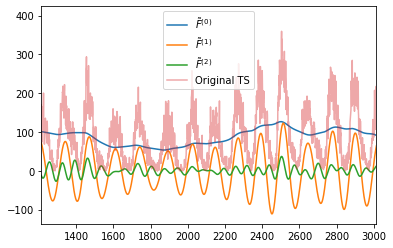

In [0]:
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("")
plt.xlabel(r"")
plt.ylabel("")
plt.xlim(1213, 3013)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/Daily_temp.csv")
#data = np.array(data)
print(data)
print(len(data))

        12
0       12
1        3
2        0
3        0
4        0
...    ...
36884  162
36885  162
36886  151
36887  152
36888  119

[36889 rows x 1 columns]
36889


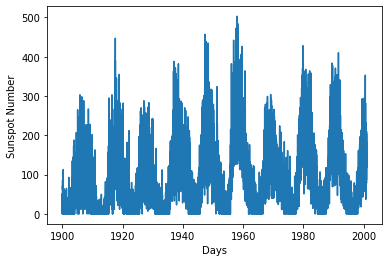

In [0]:
time = pd.date_range('1/1/1900', '30/12/2000', freq='1D')
first_col = np.arange(0, 36880, 1)
cols = [first_col, data]
accel_1 = (data**2).sum(axis=1)**0.5
#accel_1.index /= 50

plt.plot(time, accel_1)
plt.xlabel(r"Days")
plt.ylabel("Sunspot Number")
plt.title("");

In [0]:
start = 0
end = 36889 
window = 4015
accel_ssa = SSA(accel_1.loc[start:end], window)

In [0]:
height = accel_ssa.sigma()[0:100]
x = np.arange(100)
plt.scatter(x, height, color="red")

NameError: ignored